In [1]:
import sys

import clip
import gradio as gr
import hydra
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import train
import yaml
from dalle2_pytorch import DiffusionPriorNetwork
from omegaconf import DictConfig, OmegaConf
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
from tqdm.auto import tqdm

sys.path.append("stylegan3")
import dnnlib
import legacy
from clip2latent import train_utils
from clip2latent.latent_prior import ZWPrior
from clip2latent.train_utils import (compute_val, denormalise_data, make_grid,
                                     make_image_val_data, make_text_val_data)

# checkpoint = "/home/jpinkney/code/clip2latent/outputs/2022-05-18/03-53-19/checkpoints/20220518-035604/000625.ckpt"
checkpoint = "/home/jpinkney/code/clip2latent/outputs/2022-05-21/15-40-12/checkpoints/20220521-154047/000550.ckpt"
use_ema = True
device = "cuda:1"
data = torch.load(checkpoint, map_location="cpu")
# cfg = data["cfg"]
cfg_file = "/home/jpinkney/code/clip2latent/outputs/2022-05-21/15-40-12/.hydra/config.yaml"
cfg = OmegaConf.load(cfg_file)
print(cfg)

print(f"loading diffusion model")
prior_network = DiffusionPriorNetwork(**cfg["model"]["network"]).to(device)
diffusion_prior = ZWPrior(prior_network, **cfg["model"]["diffusion"]).to(device)
state_dict = data["state_dict"]
if use_ema:
    ema_key = "ema_diffusion_prior.ema_model."
    prior_dict = {k.replace(ema_key,""): v for k,v in state_dict.items() if k.startswith(ema_key)}
diffusion_prior.load_state_dict(prior_dict)

print("loading generator")
# Load eval models
with dnnlib.util.open_url(cfg["data"]["sg_pkl"]) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

print("loading clip")
clip_model, _ = clip.load(cfg["data"]["clip_variant"], device=device)

print("done")
# FIXME
# w = torch.load(hydra.utils.to_absolute_path(cfg["data"]["latent_path"]))
# stats = {
        # "w": train_utils.make_data_stats(w),
    # }
stats, _ = train.load_data(cfg["data"])
n_samples = 2

@torch.no_grad()
def greet(text_samples, cond_scale):
    diffusion_prior.eval()
    images = []
    text = clip.tokenize(text_samples).to(device)
    text_features = clip_model.encode_text(text)
    out = diffusion_prior.p_sample_loop((n_samples, 512), {"text_embed": text_features.tile(n_samples, 1)}, cond_scale=cond_scale)
    normalize = transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

    pred_w_clip_features = []
    pred_w = denormalise_data(out, *stats["w"])
    for w in tqdm(pred_w):
        out = G.synthesis(w.tile(1,18,1))
        images.append(out)
        clip_in = 0.5*F.interpolate(out, (224,224), mode="area") + 0.5
        image_features = clip_model.encode_image(normalize(clip_in))
        pred_w_clip_features.append(image_features)

    pred_w_clip_features = torch.cat(pred_w_clip_features, dim=0)
    sim = torch.cosine_similarity(pred_w_clip_features, text_features)
    sim, idxs = torch.sort(sim, descending=True)
    images = torch.cat(images, dim=0)
    images = images[idxs, ...]
    print(sim)

    grid = train_utils.make_grid(images)

    return grid

/home/jpinkney/miniconda3/envs/clip2latent/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'model': {'network': {'dim': 512, 'num_timesteps': 1000, 'depth': 12, 'dim_head': 64, 'heads': 12}, 'diffusion': {'image_embed_dim': 512, 'timesteps': 1000, 'cond_drop_prob': 0.2, 'image_embed_scale': 1.0, 'beta_schedule': 'cosine', 'predict_x_start': True}}, 'device': 'cuda:0', 'data': {'bs': 512, 'format': 'webdataset', 'path': 'data/webdataset/sg2-ffhq-1024-clip/{00000..99}.tar', 'noise_scale': 0.75, 'sg_pkl': 'https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan2/versions/1/files/stylegan2-ffhq-1024x1024.pkl', 'clip_variant': 'ViT-B/32'}, 'val': {'n_im_val_samples': 16, 'text_val_samples': ["A photograph of a young man's with a beard", "A photograph of a old woman's face with grey hair", 'A photograph of a child at a birthday party', 'A picture of a face outside in bright sun in front of green grass', 'This man has bangs arched eyebrows curly hair and a small nose', 'A photo of Barack Obama', 'An arctic explorer', "A clown's face covered in make up"]}, 'train': {'loop': {

  0%|                                                                                                                                                                                                                                                | 0/2 [00:00<?, ?it/s]

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:06<00:00, 33.42s/it]

Done.
tensor([0.2023, 0.1996], device='cuda:1', dtype=torch.float16)


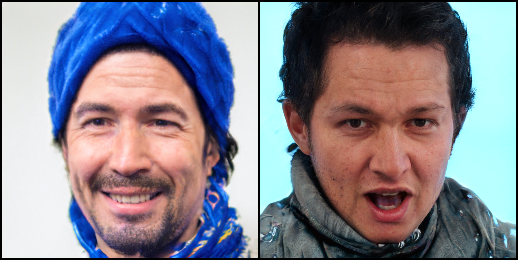

In [2]:
greet("sample", 1.0)

In [44]:

skip = 50
@torch.no_grad()
def p_sample_loop(self, shape, text_cond, cond_scale = 1.):
    device = self.betas.device

    b = shape[0]
    image_embed = torch.randn(shape, device=device)

    if self.init_image_embed_l2norm:
        image_embed = l2norm(image_embed) * self.image_embed_scale

    for i in tqdm(reversed(range(0, self.num_timesteps, skip)), desc='sampling loop time step', total=self.num_timesteps//skip):
        times = torch.full((b,), i, device = device, dtype = torch.long)
        image_embed = self.p_sample(image_embed, times, text_cond = text_cond, cond_scale = cond_scale)

    return image_embed

from functools import partial
diffusion_prior.p_sample_loop = p_sample_loop.__get__(diffusion_prior, ZWPrior)

In [45]:
last_alpha_cumprod = 1.0
new_betas = []
for i, alpha_cumprod in enumerate(diffusion_prior.alphas_cumprod):
    if i%skip == 0:
        new_betas.append(1 - alpha_cumprod / last_alpha_cumprod)
        last_alpha_cumprod = alpha_cumprod
new_betas = torch.tensor(new_betas)

betas = new_betas
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis = 0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value = 1.)

posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)
posterior_mean_coef1 = betas * torch.sqrt(alphas_cumprod_prev) / (1. - alphas_cumprod)
posterior_mean_coef2 = (1. - alphas_cumprod_prev) * torch.sqrt(alphas) / (1. - alphas_cumprod)

diffusion_prior.posterior_variance *= 0
diffusion_prior.posterior_mean_coef1 *= 0
diffusion_prior.posterior_mean_coef2 *= 0

diffusion_prior.posterior_variance[::skip] = posterior_variance
diffusion_prior.posterior_mean_coef1[::skip] = posterior_mean_coef1
diffusion_prior.posterior_mean_coef2[::skip] = posterior_mean_coef2

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 37.59it/s]


tensor([0.3105, 0.2991], device='cuda:1', dtype=torch.float16)


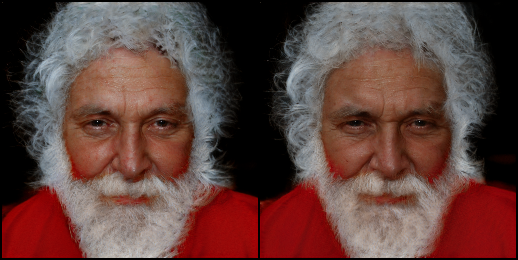

In [77]:
greet("A photograph of Father Christmas", 5.0)

In [47]:
@torch.no_grad()
def prog_p_sample_loop(self, shape, text_cond, cond_scale = 1.):
    device = self.betas.device

    b = shape[0]
    image_embed = torch.randn(shape, device=device)

    if self.init_image_embed_l2norm:
        image_embed = l2norm(image_embed) * self.image_embed_scale

    for i in tqdm(reversed(range(0, self.num_timesteps, skip)), desc='sampling loop time step', total=self.num_timesteps//skip):
        times = torch.full((b,), i, device = device, dtype = torch.long)
        out = self.p_sample(image_embed, times, text_cond = text_cond, cond_scale = cond_scale)
        yield out
        image_embed = out


from functools import partial
diffusion_prior.prog_p_sample_loop = prog_p_sample_loop.__get__(diffusion_prior, ZWPrior)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


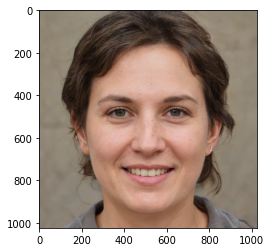

In [58]:
mean_w = stats["w"][0].tile(1,18,1).to(device)
out = G.synthesis(mean_w)
im = 0.5*out[0].permute(1,2,0).detach().cpu() + 0.5
plt.imshow(im)
plt.show()

In [115]:
from IPython.display import clear_output
@torch.no_grad()
def greet_prog(text_samples, cond_scale):
    diffusion_prior.eval()
    text = clip.tokenize(text_samples).to(device)
    text_features = clip_model.encode_text(text)
    normalize = transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

    n = 20
    scale = np.linspace(2, 1, n)
    for idx, pred_w in enumerate(diffusion_prior.prog_p_sample_loop(
        (n_samples, 512),
        {"text_embed": text_features.tile(n_samples, 1)},
        cond_scale=cond_scale,
    )):
        images_list = []
        pred_w = denormalise_data(pred_w.clone(), *stats["w"])
    
        for w in pred_w:
            direction = (w.tile(1,18,1) - mean_w)
            # print(direction[0].norm())
            this_w = scale[idx]*direction + mean_w
            out = G.synthesis(this_w, noise_mode="const")
            images_list.append(out)
            
        images = torch.cat(images_list, dim=0)
        grid = train_utils.make_grid(images)

        yield grid

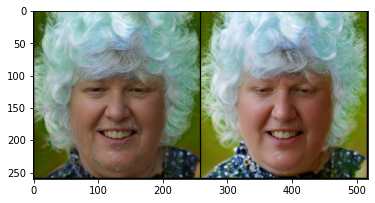

sampling loop time step: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.76it/s]


In [127]:
import matplotlib.pyplot as plt

for im in greet_prog("A photograph of an Boris Johnson", 5):
    clear_output(wait=True)
    plt.imshow(im)
    plt.show()